#### RQ1: How does the logical consistency of the CBM change when introducing the requirements via Fuzzy Loss

- This RQ aims to evaluate the logical consistency of the CBM and validate the claim that the FuzzyLoss CBM learned the rules and adheres to them on the GTSRB in distribution dataset.

In [ ]:
# imports
import os
from pathlib import Path
import torch

# changing the cwd to be source for all the imports to continue working
os.chdir("../src")  # Change to project root directory

from models.architectures import CBMSequentialEfficientNetFCN
from train_cbm import cbm_load_config
from models.trainer.cbm_trainer import CBMTrainer
from rule_eval import construct_full_graph

# Import utility functions
from analysis_utils import (
    get_dataset_predictions,
    analyze_fuzzy_loss_single_model,
    compare_fuzzy_losses,
    analyze_rule_violations,
    compare_violations,
    print_fuzzy_loss_results,
    print_violation_results,
)

In [ ]:
# model configs and model loading
baseline_cbm_config = cbm_load_config(Path("../files/configs/GTSRB_CBM_config_loading.yaml"))
baseline_cbm = CBMSequentialEfficientNetFCN(baseline_cbm_config)

fuzzy_cbm_config = cbm_load_config(Path("../files/configs/GTSRB_CBM_config_best_trial_loading.yaml"))
fuzzy_cbm = CBMSequentialEfficientNetFCN(fuzzy_cbm_config)

Directory 'experiments/20251022_161538_s42' created successfully.
Directory 'experiments/20251022_161538_s42' created successfully.


In [ ]:
# model paths for loading models
# gt_label_predictor = Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt")
# baseline_cbm_concept_predictor_path = Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224526_s687_baseline_concept_predictor_best_model.pt")
# baseline_cbm_label_predictor_path = gt_label_predictor
# fuzzy_cbm_concept_predictor_path = Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/best-fuzzy/models/20251010_102822_concept_predictor_best_model.pt")
# fuzzy_cbm_label_precitor_path = gt_label_predictor

In [ ]:
# model paths for loading models
# gt_label_predictor = Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt")
# baseline_cbm_concept_predictor_path = Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224601_s907_baseline_concept_predictor_best_model.pt")
# baseline_cbm_label_predictor_path = gt_label_predictor
# fuzzy_cbm_concept_predictor_path = Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223819_s269_concept_predictor_best_model.pt")
# fuzzy_cbm_label_precitor_path = gt_label_predictor

In [ ]:
# model paths for loading models
gt_label_predictor = Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt")
baseline_cbm_concept_predictor_path = Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224601_s907_baseline_concept_predictor_best_model.pt")
baseline_cbm_label_predictor_path = gt_label_predictor
fuzzy_cbm_concept_predictor_path = Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223819_s269_concept_predictor_best_model.pt")
fuzzy_cbm_label_precitor_path = gt_label_predictor

In [ ]:
# Load the baseline model components weights
baseline_cbm.concept_predictor.load_state_dict(
    torch.load(baseline_cbm_concept_predictor_path, map_location=baseline_cbm_config.device, weights_only=True)
)
baseline_cbm.label_predictor.load_state_dict(
    torch.load(baseline_cbm_label_predictor_path, map_location=baseline_cbm_config.device, weights_only=True)
)

# Load the fuzzy model components weights
fuzzy_cbm.concept_predictor.load_state_dict(
    torch.load(fuzzy_cbm_concept_predictor_path, map_location=fuzzy_cbm_config.device, weights_only=True)
)
fuzzy_cbm.label_predictor.load_state_dict(
    torch.load(fuzzy_cbm_label_precitor_path, map_location=fuzzy_cbm_config.device, weights_only=True)
)

# Set models to evaluation mode
baseline_cbm.eval()
fuzzy_cbm.eval()

print(f"  Baseline CBM: {baseline_cbm_concept_predictor_path.parent}")
print(f"  Fuzzy CBM:    {fuzzy_cbm_concept_predictor_path.parent}")

  Baseline CBM: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm
  Fuzzy CBM:    /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing


In [ ]:
# Load GTSRB Dataset
dataset_factory = baseline_cbm_config.dataset.factory(
    seed=baseline_cbm_config.seed, config=baseline_cbm_config.dataset
).set_dataloaders()

train_loader = dataset_factory.train_dataloader
val_loader = dataset_factory.val_dataloader
test_loader = dataset_factory.test_dataloader

print(f"  Train samples: {len(dataset_factory.train_dataset)}")
print(f"  Val samples:   {len(dataset_factory.val_dataset)}")
print(f"  Test samples:  {len(dataset_factory.test_dataset)}")

train_transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
test_transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
  Train samples: 31368
  Val samples:   7841
  Test samples:  12630


In [ ]:
# Load rule checker
rule_checker = construct_full_graph()#

In [ ]:
# Setup Trainers and Get Fuzzy Loss Function
baseline_cbm_trainer = CBMTrainer(
    config=baseline_cbm_config,
    model=baseline_cbm,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
)

fuzzy_cbm_trainer = CBMTrainer(
    config=fuzzy_cbm_config,
    model=fuzzy_cbm,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
)

# Get the fuzzy loss function
neutral_fuzzy_loss = fuzzy_cbm_trainer.concept_predictor_trainer.criterion

In [ ]:
def compare_models(
        test_loader, 
        baseline_cbm,
        baseline_cbm_config,
        fuzzy_cbm, 
        fuzzy_cbm_config,
        concept_pred_threshold=0.5,
        verbose=False
):
    if verbose:
        # Cell: GTSRB Analysis (In-Distribution)
        print("="*80)
        print("ANALYZING GTSRB DATASET (In-Distribution)")
        print("="*80)

        # Get predictions from both models
        print("\nGetting predictions from both models...")
    baseline_preds_gtsrb = get_dataset_predictions(
        baseline_cbm, test_loader, baseline_cbm_config.device, "GTSRB (Baseline)", concept_pred_threshold
    )
    fuzzy_preds_gtsrb = get_dataset_predictions(
        fuzzy_cbm, test_loader, fuzzy_cbm_config.device, "GTSRB (Fuzzy)", concept_pred_threshold
    )

    # ============================================================================
    # FUZZY LOSS ANALYSIS
    # ============================================================================
    if verbose:
        print("\n" + "="*80)
        print("FUZZY LOSS ANALYSIS - GTSRB")
        print("="*80)

    baseline_fuzzy_gtsrb = analyze_fuzzy_loss_single_model(
        baseline_preds_gtsrb['logits'], 
        baseline_preds_gtsrb['predictions'],
        neutral_fuzzy_loss, 
        'Baseline CBM', 
        'GTSRB'
    )

    fuzzy_fuzzy_gtsrb = analyze_fuzzy_loss_single_model(
        fuzzy_preds_gtsrb['logits'], 
        fuzzy_preds_gtsrb['predictions'],
        neutral_fuzzy_loss, 
        'Fuzzy CBM', 
        'GTSRB'
    )

    fuzzy_comparison_gtsrb = compare_fuzzy_losses(baseline_fuzzy_gtsrb, fuzzy_fuzzy_gtsrb)

    if verbose:
        print_fuzzy_loss_results(baseline_fuzzy_gtsrb)
        print_fuzzy_loss_results(fuzzy_fuzzy_gtsrb, fuzzy_comparison_gtsrb)

        # Display per-rule comparison table
        print("\n" + "="*80)
        print("PER-RULE FUZZY LOSS COMPARISON")
        print("="*80)
        print("\n" + fuzzy_comparison_gtsrb['rule_comparison'].to_string(index=False))

    # ============================================================================
    # RULE VIOLATION ANALYSIS
    # ============================================================================
    if verbose:
        print("\n" + "="*80)
        print("RULE VIOLATION ANALYSIS - GTSRB")
        print("="*80)

    baseline_viols_gtsrb = analyze_rule_violations(
        baseline_preds_gtsrb['predictions'], 
        'GTSRB', 
        'Baseline CBM', 
        rule_checker
    )

    fuzzy_viols_gtsrb = analyze_rule_violations(
        fuzzy_preds_gtsrb['predictions'], 
        'GTSRB', 
        'Fuzzy CBM', 
        rule_checker
    )

    violation_comparison_gtsrb = compare_violations(baseline_viols_gtsrb, fuzzy_viols_gtsrb)

    if verbose:
        print_violation_results(baseline_viols_gtsrb)
        print_violation_results(fuzzy_viols_gtsrb, violation_comparison_gtsrb)

        # Display per-constraint comparison table
        print("\n" + "="*80)
        print("PER-CONSTRAINT VIOLATION COMPARISON")
        print("="*80)
        print("\n" + violation_comparison_gtsrb['constraint_comparison'].to_string(index=False))

    # ============================================================================
    # SUMMARY
    # ============================================================================
    if verbose:
        print("\n" + "="*80)
        print("GTSRB ANALYSIS SUMMARY")
        print("="*80)

        print(f"\nLogical Consistency Improvements:")
        print(f"  Fuzzy Loss Reduction:     {fuzzy_comparison_gtsrb['relative_reduction_pct']:.2f}%")
        print(f"  Violation Rate Reduction: {violation_comparison_gtsrb['relative_improvement_pct']:.2f}%")

        print(f"\nKey Metrics:")
        print(f"  Baseline CBM:")
        print(f"    - Fuzzy Loss:      {baseline_fuzzy_gtsrb['fuzzy_loss']:.10f}")
        print(f"    - Violation Rate:  {baseline_viols_gtsrb['violation_rate']:.2f}%")
        print(f"  Fuzzy CBM:")
        print(f"    - Fuzzy Loss:      {fuzzy_fuzzy_gtsrb['fuzzy_loss']:.10f}")
        print(f"    - Violation Rate:  {fuzzy_viols_gtsrb['violation_rate']:.2f}%")

        if fuzzy_comparison_gtsrb['relative_reduction_pct'] > 0 and violation_comparison_gtsrb['relative_improvement_pct'] > 0:
            print(f"\n✓ Fuzzy CBM shows improved logical consistency on GTSRB")
            print(f"  Both fuzzy loss and violation rate metrics confirm the improvement")
        else:
            print(f"\n⚠ Mixed results - review individual metrics above")

    return (fuzzy_comparison_gtsrb,
            violation_comparison_gtsrb,
            baseline_fuzzy_gtsrb,
            baseline_viols_gtsrb,
            fuzzy_fuzzy_gtsrb,
            fuzzy_viols_gtsrb,)

In [ ]:
(fuzzy_comparison_gtsrb_05,
 violation_comparison_gtsrb_05,
 baseline_fuzzy_gtsrb_05,
 baseline_viols_gtsrb_05,
 fuzzy_fuzzy_gtsrb_05,
 fuzzy_viols_gtsrb_05,) = compare_models(
                        test_loader, 
                        baseline_cbm,
                        baseline_cbm_config,
                        fuzzy_cbm, 
                        fuzzy_cbm_config,
                        concept_pred_threshold=0.5
                )

Getting GTSRB (Fuzzy) predictions: 100%|██████████| 99/99 [00:30<00:00,  3.23it/s]


In [ ]:
(fuzzy_comparison_gtsrb_07,
 violation_comparison_gtsrb_07,
 baseline_fuzzy_gtsrb_07,
 baseline_viols_gtsrb_07,
 fuzzy_fuzzy_gtsrb_07,
 fuzzy_viols_gtsrb_07,) = compare_models(
                        test_loader, 
                        baseline_cbm,
                        baseline_cbm_config,
                        fuzzy_cbm, 
                        fuzzy_cbm_config,
                        concept_pred_threshold=0.7
                )

Getting GTSRB (Fuzzy) predictions: 100%|██████████| 99/99 [00:30<00:00,  3.22it/s]


In [ ]:
(fuzzy_comparison_gtsrb_08,
 violation_comparison_gtsrb_08,
 baseline_fuzzy_gtsrb_08,
 baseline_viols_gtsrb_08,
 fuzzy_fuzzy_gtsrb_08,
 fuzzy_viols_gtsrb_08,) = compare_models(
                        test_loader, 
                        baseline_cbm,
                        baseline_cbm_config,
                        fuzzy_cbm, 
                        fuzzy_cbm_config,
                        concept_pred_threshold=0.8
                )

Getting GTSRB (Fuzzy) predictions: 100%|██████████| 99/99 [00:30<00:00,  3.23it/s]


In [ ]:
(fuzzy_comparison_gtsrb_09,
 violation_comparison_gtsrb_09,
 baseline_fuzzy_gtsrb_09,
 baseline_viols_gtsrb_09,
 fuzzy_fuzzy_gtsrb_09,
 fuzzy_viols_gtsrb_09,) = compare_models(
                        test_loader, 
                        baseline_cbm,
                        baseline_cbm_config,
                        fuzzy_cbm, 
                        fuzzy_cbm_config,
                        concept_pred_threshold=0.9
                )

Getting GTSRB (Fuzzy) predictions: 100%|██████████| 99/99 [00:31<00:00,  3.18it/s]


In [ ]:
rule_mapping = {
    "exactly_one_shape": "R1",           # Every traffic sign must have exactly one shape
    "exactly_one_main_colour": "R2",     # Every traffic sign must have exactly one main colour
    "at_most_one_border_colour": "R3",   # Every traffic sign must have at most one border colour
    "no_symbols_exactly_two_colours": "R4",  # If a sign has no symbols it must have exactly two colours
    "warning_sign_exclusivity": "R5",    # If a sign has exactly one warning symbol it can have no other symbols
    "at_most_one_warning": "R6",         # Every traffic has at most one warning symbol
    "warning_implies_border_red": "R7",  # If a traffic sign has a warning symbols its border colour is red
    "warning_implies_main_white": "R8"   # If a traffic sign has a warning symbols its main colour is white
}

In [ ]:
violation_comparison_gtsrb_05['constraint_comparison'].assign(constraint_id = lambda x: x["Constraint"].map(rule_mapping))

,Constraint,Baseline Count,Fuzzy CBM Count,Improvement,Improvement %,constraint_id
0,at_most_one_warning,1,2,-1,-100.000000,R6
2,exactly_one_shape,3,4,-1,-33.333333,R1
3,no_symbols_exactly_two_colours,6,7,-1,-16.666667,R4
1,exactly_one_main_colour,1,3,-2,-200.000000,R2
4,warning_sign_exclusivity,0,3,-3,0.000000,R5


In [ ]:
violation_comparison_gtsrb_07['constraint_comparison'].assign(constraint_id = lambda x: x["Constraint"].map(rule_mapping))

,Constraint,Baseline Count,Fuzzy CBM Count,Improvement,Improvement %,constraint_id
2,no_symbols_exactly_two_colours,10,9,1,10.000000,R4
0,exactly_one_main_colour,2,4,-2,-100.000000,R2
3,warning_sign_exclusivity,0,2,-2,0.000000,R5
1,exactly_one_shape,3,8,-5,-166.666667,R1


In [ ]:
violation_comparison_gtsrb_08['constraint_comparison'].assign(constraint_id = lambda x: x["Constraint"].map(rule_mapping))

,Constraint,Baseline Count,Fuzzy CBM Count,Improvement,Improvement %,constraint_id
2,no_symbols_exactly_two_colours,12,9,3,25.0,R4
3,warning_sign_exclusivity,0,1,-1,0.0,R5
1,exactly_one_shape,5,9,-4,-80.0,R1
0,exactly_one_main_colour,2,6,-4,-200.0,R2


In [ ]:
violation_comparison_gtsrb_09['constraint_comparison'].assign(constraint_id = lambda x: x["Constraint"].map(rule_mapping))

,Constraint,Baseline Count,Fuzzy CBM Count,Improvement,Improvement %,constraint_id
2,no_symbols_exactly_two_colours,16,12,4,25.000000,R4
3,warning_sign_exclusivity,0,1,-1,0.000000,R5
1,exactly_one_shape,7,10,-3,-42.857143,R1
0,exactly_one_main_colour,4,8,-4,-100.000000,R2


: 

# Accuracy with new threshold

In [ ]:
fuzzy_cbm_trainer.concept_predictor_trainer.prediction_threshold = 0.5
baseline_cbm_trainer.concept_predictor_trainer.prediction_threshold = 0.5

In [ ]:
fuzzy_cbm_trainer.concept_predictor_trainer.test(test_loader, mode="test")

prediction_threshold: 0.5


Test Evaluation: 100%|██████████| 99/99 [00:30<00:00,  3.21it/s]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9540
           1       1.00      1.00      1.00       630
           2       1.00      1.00      1.00      1770
           3       1.00      0.99      1.00       690
           4       1.00      1.00      1.00       960
           5       1.00      1.00      1.00      9180
           6       1.00      1.00      1.00      8160
           7       1.00      1.00      1.00      3510
           8       1.00      0.99      1.00       690
           9       1.00      1.00      1.00       270
          10       1.00      1.00      1.00      4320
          11       1.00      0.97      0.99       900
          12       1.00      0.97      0.99       510
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       750
          15       1.00      0.99      0.99       450
          16       1.00      1.00      1.00       660
          17       0.98    

(None, 0.9996096411276215)

In [ ]:
baseline_cbm_trainer.concept_predictor_trainer.test(test_loader)

prediction_threshold: 0.5


Val [98/99] | Loss 0.0000079325 : 100%|██████████| 99/99 [00:31<00:00,  3.17it/s]


(2.5566560996096784e-07, 0.9996188477048004)

In [ ]:
fuzzy_cbm_trainer.concept_predictor_trainer.prediction_threshold = 0.9
baseline_cbm_trainer.concept_predictor_trainer.prediction_threshold = 0.9

In [ ]:
fuzzy_cbm_trainer.concept_predictor_trainer.test(test_loader)

prediction_threshold: 0.9


Val [98/99] | Loss 0.0122881895 : 100%|██████████| 99/99 [00:32<00:00,  3.02it/s]


(2.8275133216483923e-06, 0.9995415124564989)

In [ ]:
baseline_cbm_trainer.concept_predictor_trainer.test(test_loader)

prediction_threshold: 0.9


Val [98/99] | Loss 0.0000057526 : 100%|██████████| 99/99 [00:30<00:00,  3.23it/s]


(2.556642926054989e-07, 0.9995967519195713)

# Constraint Violation plot

In [ ]:
constr_ids = {'No symbols => 2 colors':'R4', 
 'Main color constraint':'R2',
 'Shape constraint': 'R1', 
 'Warning concepts constraint':'R6'
 }

In [ ]:
df_melt = violation_comparison_gtsrb_07['constraint_comparison'].rename(columns={
    'Constraint': 'Constraint Name',
    'Baseline Count': 'VCBM',
    'Fuzzy CBM Count': 'ReqAware'
}).melt(
    id_vars=['Constraint Name'],
    value_vars=['VCBM', 'ReqAware'],
    var_name='Model',
    value_name='Violation Count'
)

In [ ]:
df_melt['Constraint ID'] = df_melt['Constraint Name'].map(constr_ids)
df_melt

,Constraint Name,Model,Violation Count,Constraint ID
0,exactly_one_shape,VCBM,3,NaN
1,no_symbols_exactly_two_colours,VCBM,10,NaN
2,exactly_one_main_colour,VCBM,2,NaN
3,at_most_one_warning,VCBM,0,NaN
4,warning_sign_exclusivity,VCBM,0,NaN
5,exactly_one_shape,ReqAware,2,NaN
6,no_symbols_exactly_two_colours,ReqAware,10,NaN
7,exactly_one_main_colour,ReqAware,2,NaN
8,at_most_one_warning,ReqAware,1,NaN
9,warning_sign_exclusivity,ReqAware,2,NaN


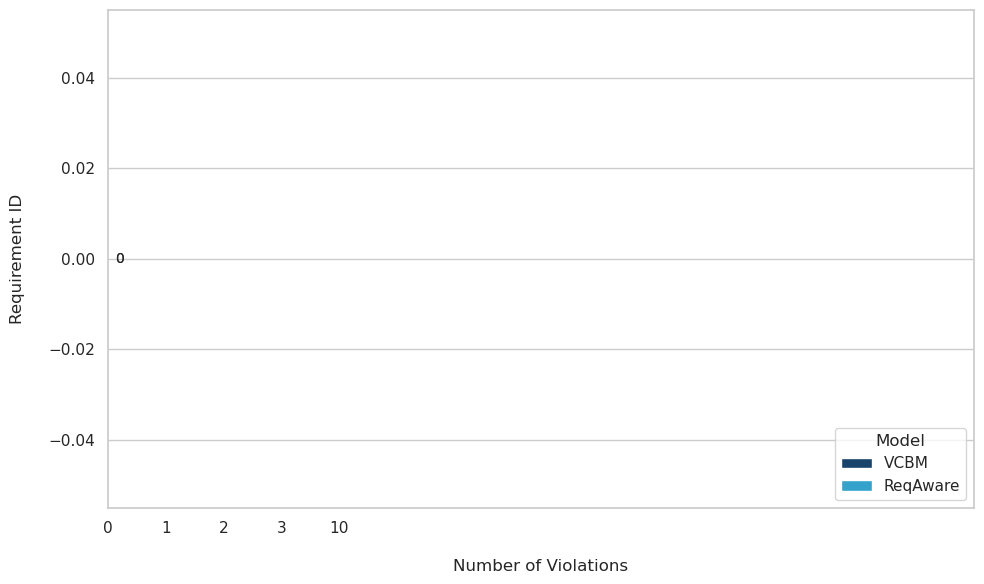

In [ ]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns


# 3. Generate the Grouped Horizontal Bar Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x='Violation Count',
    y='Constraint ID',  # Y-axis is now the Constraint Name
    hue='Model',
    data=df_melt,
    palette={'VCBM': '#0b4477', 'ReqAware': '#1cade4'}, # Blue for VCBM, Orange for FCBM
    errorbar=None
)

# Add violation count numbers at the end of the bars
for p in ax.patches:
    # Use p.get_width() for the bar value (x-coordinate) and p.get_y() + p.get_height()/2 for the y-coordinate center
    ax.annotate(format(p.get_width(), '.0f'),
                   (p.get_width(), p.get_y() + p.get_height() / 2.),
                   ha = 'left', va = 'center',
                   xytext = (5, 0), # 5 points offset to the right
                   textcoords = 'offset points',
                   fontsize=10)

# Set labels and title
# plt.title('Constraint Violation Counts: VCBM (Baseline) vs. FCBM')
plt.xlabel('\nNumber of Violations')
plt.ylabel('Requirement ID\n')

plt.legend(
    title='Model',
    loc='lower right',      # Positions the legend's corner inside the plot area
    bbox_to_anchor=(1, 0),  # Anchors the legend to the right-most (1) and bottom-most (0) part of the plot
    ncol=1
)

# Adjust x-limit to fit the annotation text
plt.xlim(0, 15)
plt.tight_layout()
plt.savefig('RQ2_constraint_violation_counts_plot.png', dpi=300)

In [ ]:
fuzzy_comparison_gtsrb_07['rule_comparison'].to_csv()

',Rule,Baseline Loss,Fuzzy CBM Loss,Improvement,Improvement %\n6,warning_implies_main_white,2.911802576832656e-09,2.784381614162612e-10,2.633364415416395e-09,90.43760165501553\n0,at_most_one_border_colour,1.1569516573217697e-05,1.6018972246456542e-06,9.967619348572043e-06,86.15415592770842\n4,no_symbols_exactly_two_colours,0.0008708378300070763,0.0006275332416407764,0.00024330458836629987,27.93913860681992\n3,at_most_one_warning,0.012296020053327084,0.011876488104462624,0.00041953194886446,3.411932861568017\n5,warning_sign_exclusivity,0.000465359422378242,0.0004635206132661551,1.8388091120868921e-06,0.3951373978181356\n2,exactly_one_shape,0.7501224875450134,0.7500489950180054,7.349252700805664e-05,0.009797403521201127\n1,exactly_one_main_colour,0.7500464916229248,0.750055730342865,-9.238719940185547e-06,-0.0012317529704318892\n7,warning_implies_border_red,3.6338540509994743e-10,1.2949734617961894e-08,-1.2586349212861947e-08,-3463.6364136309026\n'

In [ ]:
df_fuzzy_melt = fuzzy_comparison_gtsrb_07['rule_comparison'].rename(columns={
    'Rule': 'Rule Name',
    'Baseline Loss': 'VCBM',
    'Fuzzy CBM Loss': 'ReqAware'
}).melt(
    id_vars=['Rule Name'],
    value_vars=['VCBM', 'ReqAware'],
    var_name='Model',
    value_name='Violation Count'
)

In [ ]:
df_fuzzy_melt

,Rule Name,Model,Violation Count
0,warning_implies_main_white,VCBM,2.911803e-09
1,at_most_one_border_colour,VCBM,1.156952e-05
2,no_symbols_exactly_two_colours,VCBM,8.708378e-04
3,at_most_one_warning,VCBM,1.229602e-02
4,warning_sign_exclusivity,VCBM,4.653594e-04
5,exactly_one_shape,VCBM,7.501225e-01
6,exactly_one_main_colour,VCBM,7.500465e-01
7,warning_implies_border_red,VCBM,3.633854e-10
8,warning_implies_main_white,ReqAware,2.784382e-10
9,at_most_one_border_colour,ReqAware,1.601897e-06


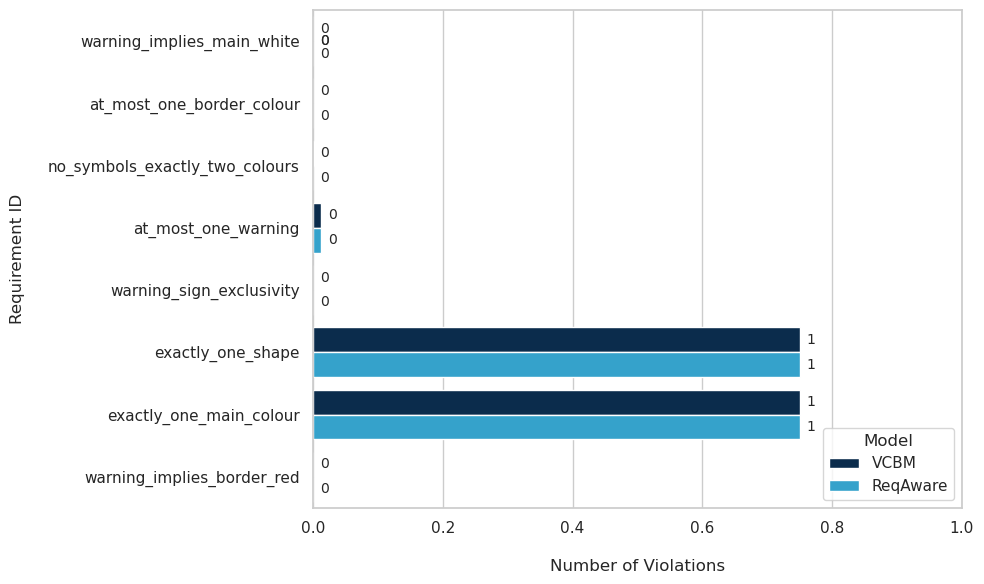

In [ ]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns


# 3. Generate the Grouped Horizontal Bar Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x='Violation Count',
    y='Rule Name',  # Y-axis is now the Constraint Name
    hue='Model',
    data=df_fuzzy_melt,
    palette={'VCBM': '#002c57', 'ReqAware': '#1cade4'}, # Blue for VCBM, Orange for FCBM
    errorbar=None
)

# Add violation count numbers at the end of the bars
for p in ax.patches:
    # Use p.get_width() for the bar value (x-coordinate) and p.get_y() + p.get_height()/2 for the y-coordinate center
    ax.annotate(format(p.get_width(), '.0f'),
                   (p.get_width(), p.get_y() + p.get_height() / 2.),
                   ha = 'left', va = 'center',
                   xytext = (5, 0), # 5 points offset to the right
                   textcoords = 'offset points',
                   fontsize=10)

# Set labels and title
# plt.title('Constraint Violation Counts: VCBM (Baseline) vs. FCBM')
plt.xlabel('\nNumber of Violations')
plt.ylabel('Requirement ID\n')

plt.legend(
    title='Model',
    loc='lower right',      # Positions the legend's corner inside the plot area
    bbox_to_anchor=(1, 0),  # Anchors the legend to the right-most (1) and bottom-most (0) part of the plot
    ncol=1
)

# Adjust x-limit to fit the annotation text
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig('RQ2_constraint_violation_counts_plot.png', dpi=300)

In [ ]:
fuzzy_comparison_gtsrb_07['rule_comparison']

,Rule,Baseline Loss,Fuzzy CBM Loss,Improvement,Improvement %
6,warning_implies_main_white,2.911803e-09,2.784382e-10,2.633364e-09,90.437602
0,at_most_one_border_colour,1.156952e-05,1.601897e-06,9.967619e-06,86.154156
4,no_symbols_exactly_two_colours,8.708378e-04,6.275332e-04,2.433046e-04,27.939139
3,at_most_one_warning,1.229602e-02,1.187649e-02,4.195319e-04,3.411933
5,warning_sign_exclusivity,4.653594e-04,4.635206e-04,1.838809e-06,0.395137
2,exactly_one_shape,7.501225e-01,7.500490e-01,7.349253e-05,0.009797
1,exactly_one_main_colour,7.500465e-01,7.500557e-01,-9.238720e-06,-0.001232
7,warning_implies_border_red,3.633854e-10,1.294973e-08,-1.258635e-08,-3463.636414
